In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
h_train = pd.read_csv(r"C:\Python\Machine Learning\Housing_Prices\train.csv")

In [76]:
##Looking at shape of data
h_train.shape

##Clearly number of features have to be reduced. We need to mine intelligent features that will be useful in building good predictive models

(1460, 81)

In [101]:
## Looking at Data:
h_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### EDA for MSSubClass:

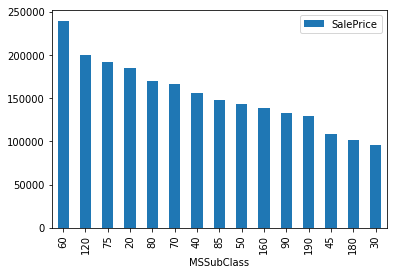

In [102]:
##EDA

mssubclass_grpby = h_train.groupby(['MSSubClass'])['SalePrice'].mean().reset_index()
mssubclass_grpby = mssubclass_grpby.sort_values('SalePrice', ascending = False)
mssubclass_grpby.index = mssubclass_grpby['MSSubClass']
mssubclass_grpby.drop(columns = ['MSSubClass']).plot.bar()

##Average sale price in MSSubClass of 2-STORY 1946 AND NEWER Houses is highest. Let's look at the standard deviation.

   MSSubClass  SalePrice
0          60     208500
1          20     181500
2          60     223500
3          70     140000
4          60     250000


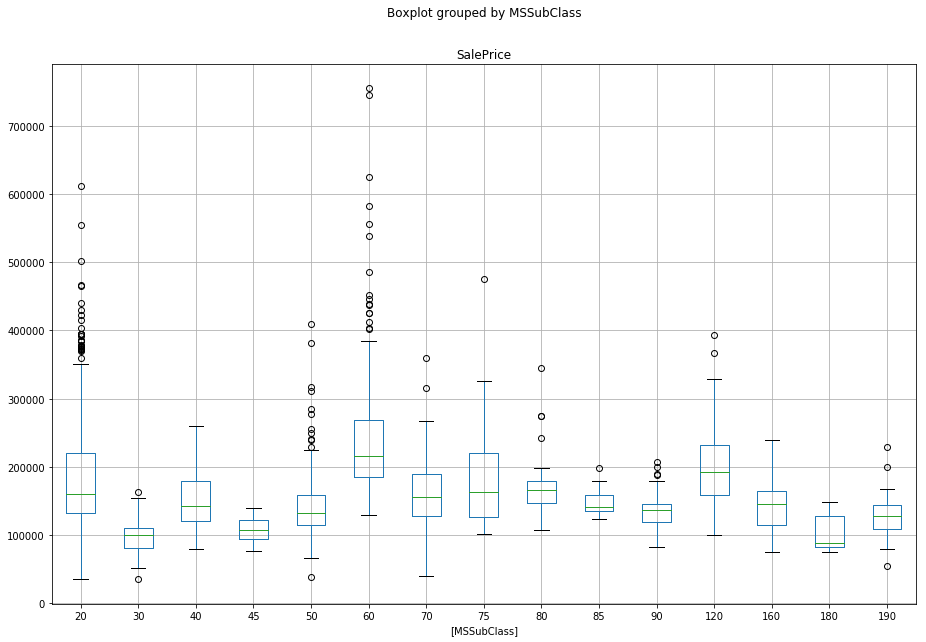

In [128]:
mssubclass = h_train[['MSSubClass', 'SalePrice']]
mssubclass.boxplot(by = 'MSSubClass', figsize = (15,10))

### EDA for MSSubClass - Observations:

In order of average Sale Price, we can rank MSSubClasses according to Value:

1) 2-Story New Houses (299)

2) 1-Story New Houses (87)

3) 2.5-Story Houses (16)

4) 1-Story New Houses (536)

5) Split Houses (58)

6) 2-Story Old Houses (60)

In general, price appears to be most sensitive to, in order (a) Whether the house is old (b) How many stories the house has

When we engineer features, we can think of collapsing categories MSSubClass categories this way.

### EDA For MSZoning

count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

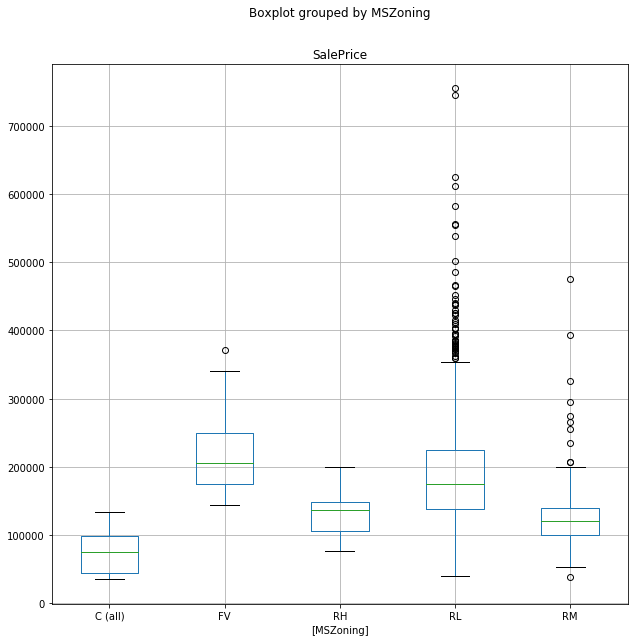

In [146]:
h_msz = h_train[['MSZoning','SalePrice']]
h_msz.boxplot(by = 'MSZoning', figsize = (10,10));

h_msz.groupby('MSZoning')['SalePrice'].agg(['sum', 'count'])


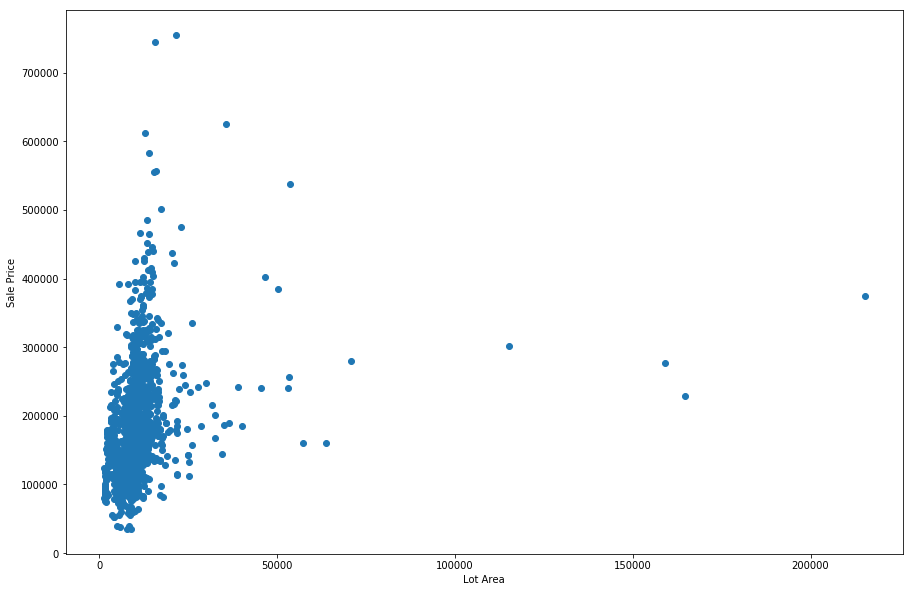

In [163]:
##Visualizing PlotArea versus SalePrice
plt.figure(figsize = (15,10))
plt.scatter(h_train.LotArea, h_train.SalePrice)
plt.xlabel('Lot Area')
plt.ylabel('Sale Price');

##Clearly Lot Area has many outliers, let's investigate:

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64


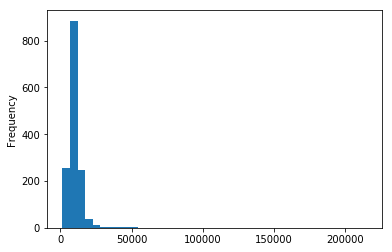

In [193]:
h_train.LotArea.plot.hist(bins = 40)
print(h_train.LotArea.describe())
##Outliers: Finding the upper bound, or ud
lotarea_iqr = h_train.LotArea.describe()['75%'] - h_train.LotArea.describe()['25%']
ub = h_train.LotArea.describe()['75%'] + 3*lotarea_iqr
h_nola = h_train.copy()
h_nola = h_nola[h_nola['LotArea'] < 23750]
h_outs = h_train[h_train['LotArea'] > 23750]

#### Looking at lot areas with huge areas:

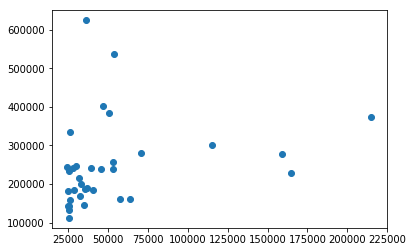

In [198]:
plt.scatter(h_outs['LotArea'], h_outs['SalePrice'])
##These are the "exotic" homes.

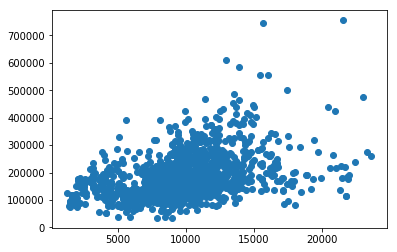

In [201]:
plt.scatter(h_nola['LotArea'], h_nola['SalePrice'])
##A lot of scatter, but homes with higher lot area sold for more in general.

### Cleaning Data

In [217]:
## Converting neighborhoods to ZIP Codes. I went through the actual locations of the places in Ames and replaced places with zipcodes.
h_nola.Neighborhood.values

teststr = h_nola.Neighborhood.unique()
teststr
ziplist = [50013, 50010, 50010, 50010, 50010, 50010, 50010, 50010, 50010, 50014, 50010, 50011, 50014, 50010, 50010,
          50014, 50014, 50010, 50010, 50010, 50010, 50010, 50010, 50011, 50014]
dictzip = {}
for i, j in zip(teststr, ziplist):
    dictzip[i] = j

{'Blmngtn': 50010,
 'Blueste': 50014,
 'BrDale': 50010,
 'BrkSide': 50010,
 'ClearCr': 50010,
 'CollgCr': 50013,
 'Crawfor': 50010,
 'Edwards': 50014,
 'Gilbert': 50010,
 'IDOTRR': 50010,
 'MeadowV': 50010,
 'Mitchel': 50010,
 'NAmes': 50011,
 'NPkVill': 50010,
 'NWAmes': 50010,
 'NoRidge': 50010,
 'NridgHt': 50010,
 'OldTown': 50010,
 'SWISU': 50011,
 'Sawyer': 50014,
 'SawyerW': 50014,
 'Somerst': 50010,
 'StoneBr': 50010,
 'Timber': 50014,
 'Veenker': 50010}

In [222]:
## Replacing all neighborhoods with zipcodes
h_nola['Neighborhood'] = [dictzip[i] for i in h_nola['Neighborhood']]

Neighborhood
50010    AxesSubplot(0.125,0.125;0.775x0.755)
50011    AxesSubplot(0.125,0.125;0.775x0.755)
50013    AxesSubplot(0.125,0.125;0.775x0.755)
50014    AxesSubplot(0.125,0.125;0.775x0.755)
Name: SalePrice, dtype: object

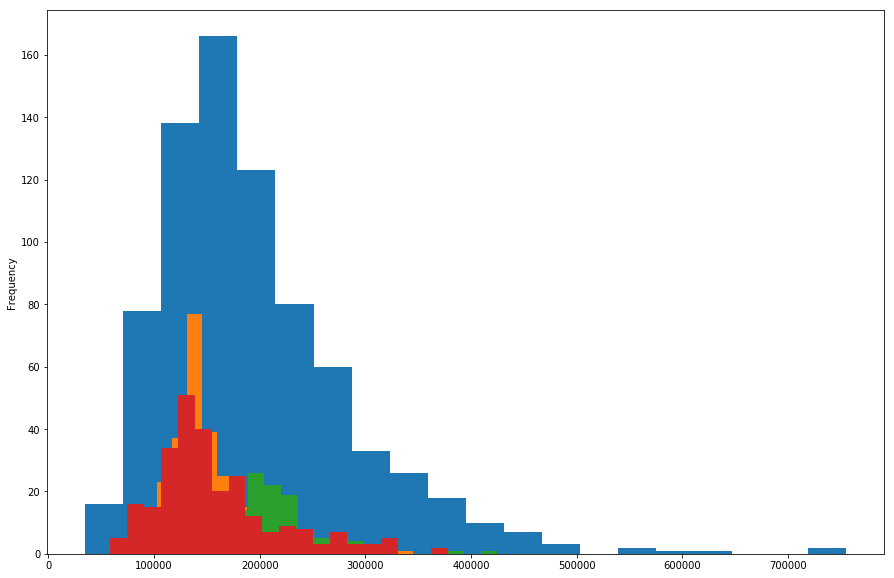

In [246]:
zipsales = h_nola.groupby(['Neighborhood'])['SalePrice']
zipsales.plot.hist(bins=20, figsize = (15,10))

### FEATURE ENGINEERING

In [260]:
## Extracting Number of Stories, this will be useful for engineering the "Lot_Volume" variable

htypes = ['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl']
stories = [1, 2, 1.5, 2, 2.5, 2, 2, 2]
dictstors = {}
for i, j in zip(htypes, stories):
    dictstors[i] = j

h_nola['HouseStyle'] = [dictstors[i] for i in h_nola['HouseStyle']]

In [264]:
##Creating Feature : LotVolume
h_nola['LotVolume'] = h_nola['LotArea'] * h_nola['HouseStyle']

In [267]:
##Creating Feature: Total_Porch_Area
h_nola['Total_Porch_Area'] = h_nola['WoodDeckSF'] + h_nola['OpenPorchSF'] + h_nola['EnclosedPorch'] + h_nola['3SsnPorch'] + h_nola['ScreenPorch']

In [292]:
##Creating Feature: House_Age
house_age_at_sale = []
for i in range(len(h_nola['YrSold'])):
    try:
        house_age_at_sale.append(min(h_nola['YrSold'][i] - h_nola['YearBuilt'][i], 
                                    h_nola['YrSold'][i] - h_nola['YearRemodAdd'][i]))
    except:
        continue

h_nola['HouseAge_AtSale'] = pd.Series(house_age_at_sale)

### There are plenty of other features we can engineer, but this should be good to build a first draft model.

In [297]:
h_nola_mod1 = h_nola[['LotFrontage', 'LotArea', 'LotVolume','Utilities', 'Neighborhood', 'Condition1', 
                      'Condition2', 'HouseStyle', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'MiscVal',
                     'Total_Porch_Area', 'HouseAge_AtSale', 'SalePrice']]

h_nola_mod1.drop(columns = ['Condition1', 'Condition2'])

,LotFrontage,LotArea,LotVolume,Utilities,Neighborhood,HouseStyle,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,MiscVal,Total_Porch_Area,HouseAge_AtSale,SalePrice
0,65.0,8450,16900.0,AllPub,50013,2.0,856,854,1710,548,0,61,5.0,208500
1,80.0,9600,9600.0,AllPub,50010,1.0,1262,0,1262,460,0,298,31.0,181500
2,68.0,11250,22500.0,AllPub,50013,2.0,920,866,1786,608,0,42,6.0,223500
3,60.0,9550,19100.0,AllPub,50010,2.0,961,756,1717,642,0,307,36.0,140000
4,84.0,14260,28520.0,AllPub,50010,2.0,1145,1053,2198,836,0,276,8.0,250000
5,85.0,14115,28230.0,AllPub,50010,2.0,796,566,1362,480,700,390,14.0,143000
6,75.0,10084,10084.0,AllPub,50010,1.0,1694,0,1694,636,0,312,2.0,307000
7,NaN,10382,20764.0,AllPub,50010,2.0,1107,983,2090,484,350,667,36.0,200000
8,51.0,6120,12240.0,AllPub,50010,2.0,1022,752,1774,468,0,295,58.0,129900
9,50.0,7420,11130.0,AllPub,50010,1.5,1077,0,1077,205,0,4,58.0,118000


In [298]:
h_nola = h_nola_mod1.drop(columns = ['Utilities'])   ##Dropping Utilities for now, let's incorporate it in advanced models

### MODELING

Models to build:

1) LASSO and Ridge Models

2) PCA to find most important Variables

3) Random Forests

4) Partial Least Squares


We compare RSS for each of the above models.

In [ ]:
##Model imports from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
